In [1]:
from helpers.utilities import *
%run helpers/notebook_setup.ipynb

In [2]:
%R source('plots/colors.R');

In [3]:
indexed_by_target_path = 'data/clean/protein/indexed_by_target.csv'
clinical_path = 'data/clean/protein/clinical_data_ordered_to_match_proteins_matrix.csv'

raw_gene_path = 'data/clean/protein/gene_levels_by_entrez.csv'
target_to_entrez_path = 'data/clean/protein/protein_to_entrez.csv'

log_matrix_filtered_path = 'data/clean/protein/log_10_filtered.csv'

In [4]:
clinical = read_csv(clinical_path, index_col=0)
raw_protein_matrix = read_csv(indexed_by_target_path, index_col=0)

In [5]:
# note: this is already limitted to the patients having the protein measurments
by_condition = clinical.Meningitis

In [6]:
%%R -i raw_protein_matrix -i by_condition
import::here(space_to_dot, dot_to_space, .from='helpers/utilities.R')
import::here(
    design_from_conditions, calculate_means, limma_fit,
    .from='helpers/differential_expression.R'
)

In [7]:
protein_matrix = read_csv(log_matrix_filtered_path, index_col=0)

In [8]:
%%R -i by_condition -i protein_matrix

limma_protein_fit = function(data=protein_matrix, conditions_vector=by_condition, ...) {
    limma_fit(data=data, conditions_vector=conditions_vector, ...)
}

diff_ebayes <- function(a, b, ...){
    fit = limma_protein_fit(a=a, b=b, ...)
    limma::eBayes(fit, trend=T, robust=T)
}

## Gene set enrichment

In [9]:
from gsea_api.molecular_signatures_db import MolecularSignaturesDatabase

db = MolecularSignaturesDatabase('data/msigdb', version='6.2')

Simple symbol-based protein-gene matching performs poorly:

In [10]:
from helpers.gse import collection_to_R, nice_reactome, calculate_overlap

In [12]:
reactome_pathways_entrez = db.load(gene_sets='c2.cp.reactome', id_type='entrez').format_names(nice_reactome)
reactome_pathways_symbol = db.load(gene_sets='c2.cp.reactome', id_type='symbols').format_names(nice_reactome)

In [13]:
calculate_overlap(reactome_pathways_symbol, protein_matrix)

12.92%


Actually, the GMT files in MSigDB are old (released 16-Jul-2018 as a point release with only minor changes). Let's fetch a modern GMT directly from Reactome:

In [14]:
# !wget https://reactome.org/download/current/ReactomePathways.gmt.zip
# !unzip ReactomePathways.gmt.zip

In [15]:
from gsea_api.molecular_signatures_db import GeneMatrixTransposed

In [16]:
reactome_new_symbol = GeneMatrixTransposed.from_gmt('ReactomePathways.gmt', name='reactome_new_symbol')

In [17]:
calculate_overlap(reactome_new_symbol, protein_matrix)

21.00%


This is still not very good.

Instead I will use Entrez ID based mapping, as described in [Gene_level_mapping.ipynb](Gene_level_mapping.ipynb) notebook:

In [18]:
raw_gene_matrix = read_csv(raw_gene_path, index_col=0)

In [19]:
assert not raw_gene_matrix.index.duplicated().any()

In [20]:
from numpy import log10

In [21]:
log10_gene_matrix = raw_gene_matrix.apply(log10)

It matches much more genes:

In [22]:
calculate_overlap(reactome_pathways_entrez, raw_gene_matrix)

55.46%


In [23]:
kegg_pathways_entrez = db.load(gene_sets='c2.cp.kegg', id_type='entrez')
calculate_overlap(reactome_pathways_entrez, raw_gene_matrix)

55.46%


In [24]:
# !cat data/LRG_RefSeqGene | cut -f 2,3 | sort | uniq > data/entrez_id_to_symbol.tsv
# even bettter:
# https://www.genenames.org/cgi-bin/download/custom?col=gd_hgnc_id&col=gd_app_sym&col=gd_status&col=md_eg_id&status=Approved&status=Entry%20Withdrawn&hgnc_dbtag=on&order_by=gd_app_sym_sort&format=text&submit=submit

In [25]:
id_to_symbol_df = read_table('data/hgnc/entrez_ids_to_gene_symbol.tsv', index_col=3)

In [26]:
id_to_symbol_df.head()

,HGNC ID,Approved symbol,Status
NCBI Gene ID(supplied by NCBI),,,
1.0,HGNC:5,A1BG,Approved
503538.0,HGNC:37133,A1BG-AS1,Approved
29974.0,HGNC:24086,A1CF,Approved
NaN,HGNC:6,A1S9T~withdrawn,Symbol Withdrawn
2.0,HGNC:7,A2M,Approved


In [27]:
id_to_symbol_df.Status.unique()

array(['Approved', 'Symbol Withdrawn', 'Entry Withdrawn'], dtype=object)

In [28]:
id_to_symbol = id_to_symbol_df[id_to_symbol_df.Status == 'Approved']['Approved symbol'].to_dict()

In [29]:
from numpy import nan

In [30]:
symbols = raw_gene_matrix.index.map(lambda entrez_id: id_to_symbol.get(float(entrez_id), nan))
raw_gene_matrix_by_symbols = copy(raw_gene_matrix)
raw_gene_matrix_by_symbols.index = symbols

In [31]:
genes_missing_symbols = raw_gene_matrix.index[raw_gene_matrix_by_symbols.index.isnull()]
sorted(genes_missing_symbols)

[4276, 12372, 1489079, 1489089, 1724716, 102723996]

In [32]:
manual_map = {
    4276.0: 'MICA',
    102723996.0: 'ICOSLG'
}

- 4276 - replaced with 100507436 but symbol stayed the same (MICA)
   > Gene ID: 4276, discontinued on 10-Nov-2010
   >
  > This record was replaced with Gene ID: 100507436
- 12372 - mouse protein
- 1489079, 1489089, 1724716 - viral proteins
- 102723996 - a recent addition, ICOS ligand https://www.ncbi.nlm.nih.gov/gene/?term=102723996

In [33]:
id_to_symbol_curated = {**id_to_symbol, **manual_map}

In [34]:
symbols_curated = raw_gene_matrix.index.map(lambda entrez_id: id_to_symbol_curated.get(float(entrez_id), nan))

In [35]:
raw_gene_matrix_by_symbols.index = symbols_curated
raw_gene_matrix_by_symbols = raw_gene_matrix_by_symbols[~raw_gene_matrix_by_symbols.index.isnull()]

However, MICA and ICOSLG are already captured by other entrez ids - so I can remove the duplicates:

In [36]:
raw_gene_matrix_by_symbols[raw_gene_matrix_by_symbols.index.duplicated(keep=False)]

,149.TMD,007.TMD,001.TMD,064.TMD,151.TMD,...,177.HC,189.HC,217.HC,221.HC,245.HC
MICA,51.75,207.25,5.65,7.05,22.0,...,10.45,11.85,6.65,11.60,11.95
MICA,51.75,207.25,5.65,7.05,22.0,...,10.45,11.85,6.65,11.60,11.95
ICOSLG,6890.40,42844.10,8329.50,16044.35,22721.1,...,153.50,91.20,114.90,288.75,554.70
ICOSLG,6890.40,42844.10,8329.50,16044.35,22721.1,...,153.50,91.20,114.90,288.75,554.70


In [37]:
raw_gene_matrix_by_symbols = raw_gene_matrix_by_symbols[~raw_gene_matrix_by_symbols.index.duplicated()]

In [38]:
calculate_overlap(reactome_new_symbol, raw_gene_matrix_by_symbols)

86.02%


Using the recent Reactome GMT mapped via entrez IDs to symbol seems good enough. Is it superior to just using the symbols provided in aptamers metadata?

In [39]:
aptamers = read_csv('data/other/relevant_aptamers.csv')

In [40]:
soma = set(symbol for symbols in aptamers.EntrezGeneSymbol.str.split(' ') for symbol in symbols)
precentage = len(reactome_new_symbol.all_identifiers & soma) / len(soma) * 100
precentage

86.73312883435584

In [41]:
len(soma), len(raw_gene_matrix_by_symbols)

(1304, 1323)

It's about the same. But I feel much more confident using the entrez-id mapping step.

In [43]:
entrez_ids = set(map(str, raw_gene_matrix.index))
symbols = set(raw_gene_matrix_by_symbols.index)

for collection, genes in [
    (kegg_pathways_entrez, entrez_ids),
    (reactome_new_symbol, symbols),
    (reactome_pathways_entrez, entrez_ids)
]:
    print(collection.name)
    collection_to_R(collection, trim_to=genes)

c2.cp.kegg
reactome_new_symbol
c2.cp.reactome


In [44]:
%%R
gse = function(data, groups, contrast, collection, nrot=9999){
    design = design_from_conditions(groups, intercept='Healthy.control')
    limma::mroast(data, collection, design=design, contrast=contrast, geneid=dimnames(data)[[1]], nrot=nrot)
}

In [45]:
log10_gene_matrix_symbols = raw_gene_matrix_by_symbols.apply(log10)

## Simple multiple rotational GSE testing is not well suited to prioritetize pathways in imbalanced dataset

Because ROAST is self-contained it performs poorly in a setting where everything is up:

### The results from recent Reactome release uncover more hits

In [46]:
%%R -o tb_top_pathways -i log10_gene_matrix
tb_top_pathways = gse(log10_gene_matrix, by_condition, 'Tuberculosis', c2.cp.reactome)
head(tb_top_pathways)

                                     NGenes PropDown PropUp Direction PValue
Apoptosis                                42        0      1        Up  1e-04
Integrin Cell Surface Interactions       38        0      1        Up  1e-04
Cell Cycle                               34        0      1        Up  1e-04
Signaling By The B Cell Receptor Bcr     28        0      1        Up  1e-04
Cell Cycle Mitotic                       26        0      1        Up  1e-04
Costimulation By The Cd28 Family         26        0      1        Up  1e-04
                                       FDR PValue.Mixed FDR.Mixed
Apoptosis                            1e-04        1e-04     1e-04
Integrin Cell Surface Interactions   1e-04        1e-04     1e-04
Cell Cycle                           1e-04        1e-04     1e-04
Signaling By The B Cell Receptor Bcr 1e-04        1e-04     1e-04
Cell Cycle Mitotic                   1e-04        1e-04     1e-04
Costimulation By The Cd28 Family     1e-04        1e-04     1e-04

In [47]:
%%R -o tb_top_pathways -i log10_gene_matrix_symbols
tb_top_pathways = gse(log10_gene_matrix_symbols, by_condition, 'Tuberculosis', reactome_new_symbol)
head(tb_top_pathways)

                                   NGenes PropDown PropUp Direction PValue
Cell Cycle                             67        0      1        Up  1e-04
Transcriptional Regulation by TP53     58        0      1        Up  1e-04
Cell Cycle, Mitotic                    56        0      1        Up  1e-04
Programmed Cell Death                  55        0      1        Up  1e-04
Apoptosis                              54        0      1        Up  1e-04
Signaling by VEGF                      41        0      1        Up  1e-04
                                     FDR PValue.Mixed FDR.Mixed
Cell Cycle                         1e-04        1e-04     1e-04
Transcriptional Regulation by TP53 1e-04        1e-04     1e-04
Cell Cycle, Mitotic                1e-04        1e-04     1e-04
Programmed Cell Death              1e-04        1e-04     1e-04
Apoptosis                          1e-04        1e-04     1e-04
Signaling by VEGF                  1e-04        1e-04     1e-04


## Using camera (on limma with trend correction) is better suited for the imbalanced dataset

- Because it is a competitive test.
- because we take advantage of the mean-variance trend correction and robust statistics

In [48]:
%%R
camera = function(a, b, data, collection, design=by_condition) {
    result = diff_ebayes(a, b, data=data, conditions_vector=design)
    # using t-statistic
    limma::cameraPR(result$t[,1], collection)
}

In [49]:
%%R -o tb_log_msig
tb_log_msig = camera('Tuberculosis', 'Healthy control', log10_gene_matrix, c2.cp.reactome)

In [50]:
tb_log_msig.head(10)

,NGenes,Direction,PValue,FDR
Rna Pol I Promoter Opening,13.0,Up,1.674224e-11,4.972446e-09
Rna Pol I Transcription,14.0,Up,9.014255e-11,1.338617e-08
Meiosis,16.0,Up,3.708488e-10,3.671403e-08
Meiotic Recombination,14.0,Up,7.226758e-10,5.365868e-08
Rna Pol I Rna Pol Iii And Mitochondrial Transcription,16.0,Up,1.353965e-09,8.042555e-08
Transcription,18.0,Up,5.185914e-09,2.567028e-07
Factors Involved In Megakaryocyte Development And Platelet Production,25.0,Up,8.569384e-05,3.635867e-03
Signaling By Scf Kit,38.0,Up,2.386632e-04,8.860371e-03
Heparan Sulfate Heparin Hs Gag Metabolism,10.0,Down,3.368020e-04,1.111447e-02
Glycosaminoglycan Metabolism,20.0,Down,5.405008e-04,1.605287e-02


In [51]:
%%R -o tb_log_new
tb_log_new = camera('Tuberculosis', 'Healthy control', log10_gene_matrix_symbols, reactome_new_symbol)

In [52]:
tb_log_new.head(10)

,NGenes,Direction,PValue,FDR
Signaling by Rho GTPases,40.0,Up,0.000062,0.041932
RHO GTPases activate PKNs,11.0,Up,0.000179,0.041932
Activation of BAD and translocation to mitochondria,12.0,Up,0.000210,0.041932
Neutrophil degranulation,128.0,Up,0.000271,0.041932
RHO GTPase Effectors,36.0,Up,0.000299,0.041932
Heparan sulfate/heparin (HS-GAG) metabolism,10.0,Down,0.000344,0.041932
Cell Cycle,67.0,Up,0.000416,0.043445
Glycosaminoglycan metabolism,20.0,Down,0.000552,0.050417
Chondroitin sulfate/dermatan sulfate metabolism,11.0,Down,0.000723,0.054624
Intrinsic Pathway for Apoptosis,24.0,Up,0.000749,0.054624


Some familiar names here:
 - "Activation of BAD and translocation to mitochondria", "Cell Cycle" (highlighted by ORA)
 - RHO GTPase and Neutrophil degranulation - there are frequent mentions in context of TB

Note:
- Using the full Reactome dataset has an advantage of increased (86% from 55%) number of genes mapped to the pathways
- but it might introduce too similar (correlated) gene sets which skew the results of tests - which is not the case for the curated collections
- when an agreement between the two methods is reached, we can rest assured that the results are correct

In [53]:
def agreement(a, b, cutoff=0.1):
    a = copy(a)
    b = copy(b)
    b['name'] = b.index
    a.index = a.index.str.lower()
    b.index = b.index.str.lower()
    for d in [a, b]:
        # this code wants to be rewritten to a regexpr
        d.index = d.index.map(lambda x: ''.join([
            c if c.isalnum() or c.isspace() else ' '
            for c in x
        ]).replace('  ', ' ').replace('  ', ' '))
    agreement = set(a[a.FDR < cutoff].index) & set(b[b.FDR < cutoff].index)
    return a.loc[agreement].merge(b.loc[agreement], left_index=True, right_index=True).sort_values('FDR_y').set_index('name')

In [54]:
tb_log_agreement = agreement(tb_log_msig, tb_log_new, cutoff=0.1)
tb_log_agreement

,NGenes_x,Direction_x,PValue_x,FDR_x,NGenes_y,Direction_y,PValue_y,FDR_y
name,,,,,,,,
Heparan sulfate/heparin (HS-GAG) metabolism,10.0,Down,0.000337,0.011114,10.0,Down,0.000344,0.041932
Glycosaminoglycan metabolism,20.0,Down,0.000541,0.016053,20.0,Down,0.000552,0.050417
Apoptosis,42.0,Up,0.005001,0.061889,54.0,Up,0.000822,0.054624
Chondroitin sulfate/dermatan sulfate metabolism,11.0,Down,0.000709,0.017554,11.0,Down,0.000723,0.054624
CS/DS degradation,6.0,Down,0.000886,0.020238,6.0,Down,0.000902,0.054952
Costimulation by the CD28 family,26.0,Up,0.002343,0.038406,28.0,Up,0.002608,0.070598
HS-GAG degradation,6.0,Down,0.002457,0.038406,6.0,Down,0.002496,0.070598
Metabolism of RNA,23.0,Up,0.001880,0.036946,34.0,Up,0.001894,0.070598


In [55]:
%%R
barplot = function(values, gene_sets, collection) {
    df = as.data.frame(values)
    df$gene = rownames(df)

    sets = collection[gene_sets]

    l = list()
    i = 0
    for(set_name in names(sets)) {
        genes = sets[[set_name]]
        for (gene in genes) {
            i = i + 1
            x = df[rownames(df) == gene, 'values']
            l[[i]] = data.frame(
                gene=gene,
                gene_set=set_name,
                values=x
            )
        }
    }
    df$gene_set = 'All genes'
    df2 = rbind(df, do.call(rbind, l))
    df2$mean = ave(df2$values, df2$gene_set)

    df2 <- transform(df2, variable=reorder(gene, values) ) 
    (
        ggplot(df2, aes(x=reorder(gene, values), y=reorder(gene_set, mean), fill=values))
        + theme_bw()
        + geom_tile(colour='white')
        + theme(
            legend.position = 'bottom',
            axis.text.x = element_text(angle = 90),
            plot.background = element_blank(),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank()
        )
        + scale_x_discrete(breaks=df2[df2$gene_set != 'All genes', 'gene'][0:0])
        + scale_fill_gradient2(low='navy', mid='white', high='red', midpoint=0)
    )
}

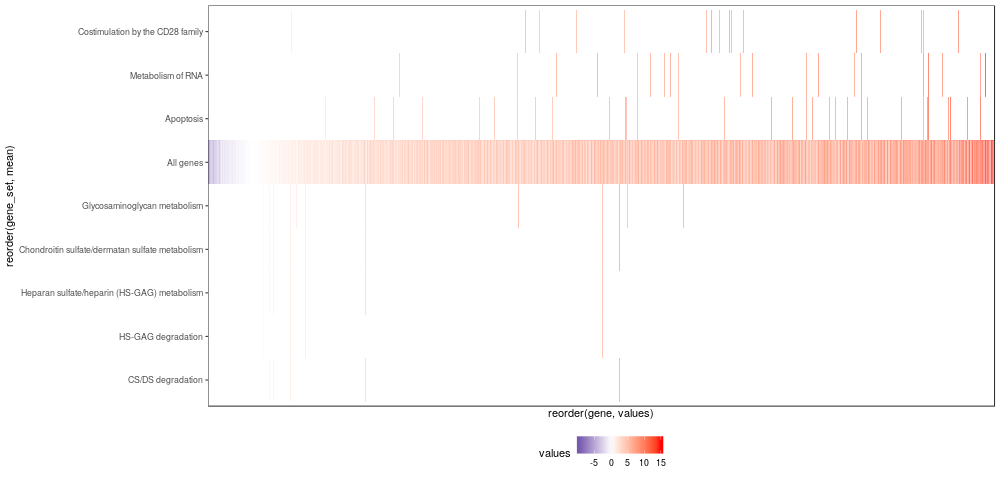

In [56]:
%%R -w 1000 -u px -i tb_log_agreement
sets_of_interest = rownames(tb_log_agreement)
result = diff_ebayes('Tuberculosis', 'Healthy control', log10_gene_matrix_symbols)
barplot(result$t[,1], sets_of_interest, reactome_new_symbol)

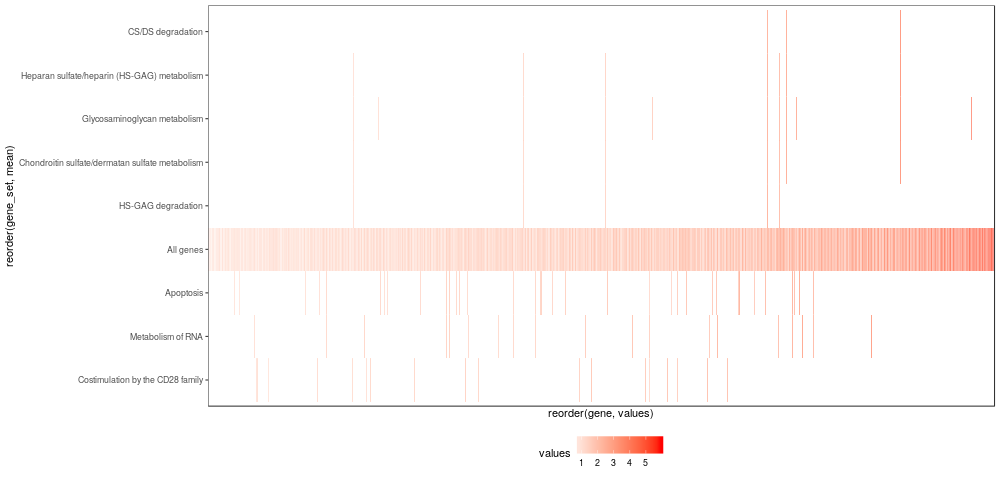

In [57]:
%%R -w 1000 -u px
barplot(rowMeans(log10_gene_matrix_symbols), sets_of_interest, reactome_new_symbol)

### TB vs crypto

In [58]:
%%R -o tb_cc_log_msig
tb_cc_log_msig = camera('Tuberculosis', 'Cryptococcal', log10_gene_matrix, c2.cp.reactome)

In [59]:
tb_cc_log_msig.head(10)

,NGenes,Direction,PValue,FDR
Rna Pol I Promoter Opening,13.0,Up,4.374749e-07,0.000063
Transcription,18.0,Up,5.856757e-07,0.000063
Meiosis,16.0,Up,9.417996e-07,0.000063
Rna Pol I Transcription,14.0,Up,9.857308e-07,0.000063
Rna Pol I Rna Pol Iii And Mitochondrial Transcription,16.0,Up,1.267866e-06,0.000063
Meiotic Recombination,14.0,Up,1.278593e-06,0.000063
Signaling By Scf Kit,38.0,Up,8.320456e-06,0.000353
Peptide Hormone Biosynthesis,8.0,Down,5.161046e-05,0.001916
Signaling By The B Cell Receptor Bcr,28.0,Up,9.258122e-05,0.003055
Glycoprotein Hormones,7.0,Down,1.151620e-04,0.003420


In [60]:
%%R -o tb_cc_log_new
tb_cc_log_new = camera('Tuberculosis', 'Cryptococcal', log10_gene_matrix_symbols, reactome_new_symbol)

In [61]:
tb_cc_log_new.head(10)

,NGenes,Direction,PValue,FDR
Cell Cycle,67.0,Up,0.000020,0.012829
"Cell Cycle, Mitotic",56.0,Up,0.000050,0.012829
Peptide hormone biosynthesis,8.0,Down,0.000053,0.012829
Glycoprotein hormones,7.0,Down,0.000117,0.021431
Assembly of collagen fibrils and other multimeric structures,10.0,Down,0.000198,0.028174
Signaling by Rho GTPases,40.0,Up,0.000231,0.028174
M Phase,35.0,Up,0.000309,0.030913
Cellular responses to external stimuli,80.0,Up,0.000338,0.030913
CREB1 phosphorylation through NMDA receptor-mediated activation of RAS signaling,8.0,Up,0.000442,0.034688
Signaling by SCF-KIT,24.0,Up,0.000475,0.034688


In [62]:
show_table(agreement(tb_cc_log_msig, tb_cc_log_new, cutoff=0.1))

,NGenes_x,Direction_x,PValue_x,FDR_x,NGenes_y,Direction_y,PValue_y,FDR_y
name,,,,,,,,
Cell Cycle,34.0,Up,7.420455e-03,0.056719,67.0,Up,0.000020,0.012829
Peptide hormone biosynthesis,8.0,Down,5.161046e-05,0.001916,8.0,Down,0.000053,0.012829
Glycoprotein hormones,7.0,Down,1.151620e-04,0.003420,7.0,Down,0.000117,0.021431
Signaling by SCF-KIT,38.0,Up,8.320456e-06,0.000353,24.0,Up,0.000475,0.034688
Apoptosis,42.0,Up,1.069480e-02,0.067258,54.0,Up,0.001569,0.053811
Post NMDA receptor activation events,7.0,Up,2.952276e-03,0.035006,22.0,Up,0.001914,0.053811
PIP3 activates AKT signaling,9.0,Up,6.014611e-03,0.051408,81.0,Up,0.003127,0.061788
TRAF6 mediated induction of NFkB and MAP kinases upon TLR7/8 or 9 activation,26.0,Up,3.064509e-03,0.035006,29.0,Up,0.004831,0.064468
Metabolism of RNA,23.0,Up,8.020807e-03,0.056719,34.0,Up,0.003603,0.064468


TODO: Cell cycle - what makes it come

## HIV?

In [63]:
hiv_status = clinical.HIVResult

In [64]:
%%R -i hiv_status -o hiv_pos_vs_neg
hiv_pos_vs_neg = camera('Positive', 'Negative', log10_gene_matrix, c2.cp.reactome, design=hiv_status)

In [65]:
hiv_pos_vs_neg.head(10)

,NGenes,Direction,PValue,FDR
Hs Gag Degradation,6.0,Down,0.008375,0.823244
Extrinsic Pathway For Apoptosis,6.0,Up,0.017753,0.823244
G Alpha Q Signalling Events,16.0,Down,0.022348,0.823244
Gastrin Creb Signalling Pathway Via Pkc And Mapk,29.0,Down,0.023289,0.823244
Regulation Of Insulin Like Growth Factor Igf Activity By Insulin Like Growth Factor Binding Proteins Igfbps,13.0,Down,0.023643,0.823244
Glycosaminoglycan Metabolism,20.0,Down,0.029601,0.823244
Other Semaphorin Interactions,6.0,Down,0.029786,0.823244
Keratan Sulfate Keratin Metabolism,6.0,Down,0.029864,0.823244
Gamma Carboxylation Transport And Amino Terminal Cleavage Of Proteins,6.0,Down,0.031089,0.823244
Class A1 Rhodopsin Like Receptors,52.0,Down,0.032779,0.823244


In [66]:
%%R -i hiv_status -o hiv_pos_vs_neg_new
hiv_pos_vs_neg_new = camera('Positive', 'Negative', log10_gene_matrix_symbols, reactome_new_symbol, design=hiv_status)

In [67]:
hiv_pos_vs_neg_new.head(10)

,NGenes,Direction,PValue,FDR
Regulation of Insulin-like Growth Factor (IGF) transport and uptake by Insulin-like Growth Factor Binding Proteins (IGFBPs),59.0,Down,0.000047,0.034399
TNFs bind their physiological receptors,25.0,Up,0.000239,0.087408
Classical antibody-mediated complement activation,9.0,Down,0.000499,0.090544
TNFR2 non-canonical NF-kB pathway,44.0,Up,0.000536,0.090544
Post-translational protein phosphorylation,47.0,Down,0.000619,0.090544
Regulation of Complement cascade,32.0,Down,0.001686,0.205388
Immunoregulatory interactions between a Lymphoid and a non-Lymphoid cell,43.0,Up,0.002665,0.263723
Creation of C4 and C2 activators,15.0,Down,0.002886,0.263723
FCGR activation,12.0,Down,0.003537,0.287314
Metabolism of Angiotensinogen to Angiotensins,9.0,Down,0.004664,0.340932


TODO: compare different pathways between groups

## Traditional GSEA

Is kind of both competitive and self-contained 

In [68]:
from gsea_api.gsea import GSEADesktop

In [69]:
from gsea_api.expression_set import ExpressionSet

In [70]:
gsea = GSEADesktop()

Notes on the FDR:
 - the cutoff of .25 was recommended for GSEA in the User Guide for exploratory anaylsis when using phenotype permutations:
    > The GSEA analysis report highlights enrichment gene sets with an FDR of less than 25% as those most likely to generate interesting hypotheses and drive further research, but provides analysis results for all analyzed gene sets. In general, given the lack of coherence in most expression datasets and the relatively small number of gene sets being analyzed, an FDR cutoff of 25% is appropriate.
 - however for viral class, we should set it to a lower value as this has fewer samples (also encouraged in the User Guide)

In [71]:
def run_gsea(a, b, matrix, curated=False, design=by_condition):
    result = gsea.run(
        ExpressionSet(matrix, design).contrast(a, b),
        reactome_pathways_entrez if curated else reactome_new_symbol,
        metric='Signal2Noise',
        permutations=1000
    )
    return concat([
        result[a.replace(' ', '_')].assign(direction='up'),
        result[b.replace(' ', '_')].assign(direction='down')
    ])[['nes', 'fdr_q-val', 'fwer_p-val', 'direction']].sort_values('fdr_q-val')

Whether to use the log transformed data is not obvious in this case. However, usually the log transform is embedded in the metric and the method was originally designed to handle natural data. Also:

> **Should I use natural or log scale data for GSEA?**
>
> We recommend using natural scale data. We used it when we calibrated the GSEA method and it seems to work well in general cases.
>
> Traditional modeling techniques, such as clustering, often benefit from data preprocessing. For example, one might filter expression data to remove genes that have low variance across the dataset and/or log transform the data to make the distribution more symmetric. The GSEA algorithm does not benefit from such preprocessing of the data.
https://software.broadinstitute.org/cancer/software/gsea/wiki/index.php/FAQ#Should_I_use_natural_or_log_scale_data_for_GSEA.3F

In [72]:
run_gsea('Tuberculosis', 'Healthy control', raw_gene_matrix_by_symbols).head()

,nes,fdr_q-val,fwer_p-val,direction
name,,,,
INNATE IMMUNE SYSTEM,2.117977,0.148085,0.080,up
NEUTROPHIL DEGRANULATION,2.136583,0.258096,0.077,up
BINDING AND UPTAKE OF LIGANDS BY SCAVENGER RECEPTORS,1.704598,0.494873,0.381,up
RESPONSE TO ELEVATED PLATELET CYTOSOLIC CA2+,1.726046,0.503820,0.354,up
AMYLOID FIBER FORMATION,1.873488,0.510202,0.193,up


Just to have a glimpse on how that would look like for log transformed data (so possibly elucidating less-obvious processes):

In [73]:
run_gsea('Tuberculosis', 'Healthy control', log10_gene_matrix_symbols).head()

,nes,fdr_q-val,fwer_p-val,direction
name,,,,
TOLL LIKE RECEPTOR 3 (TLR3) CASCADE,1.433290,0.297214,0.580,up
CELLULAR SENESCENCE,1.363102,0.301956,0.637,up
TOLL LIKE RECEPTOR 10 (TLR10) CASCADE,1.500779,0.302240,0.516,up
TOLL LIKE RECEPTOR 9 (TLR9) CASCADE,1.433470,0.305272,0.580,up
SIGNALING BY RAS MUTANTS,1.406721,0.305877,0.608,up


And using the curated dataset (not transformed):

In [74]:
run_gsea('Tuberculosis', 'Healthy control', raw_gene_matrix, curated=True).head()

,nes,fdr_q-val,fwer_p-val,direction
name,,,,
AMYLOIDS,2.021037,0.169993,0.060,up
INNATE IMMUNE SYSTEM,1.578337,0.402706,0.412,up
HEMOSTASIS,1.605637,0.412667,0.385,up
COMPLEMENT CASCADE,1.517433,0.429003,0.464,up
SIGNALLING TO ERKS,1.458186,0.433615,0.538,up


Again, there is a big difference between the results obtained using the curated and full Reactome collections,

### Crypto

In [75]:
run_gsea('Cryptococcal', 'Healthy control', raw_gene_matrix_by_symbols).head()

,nes,fdr_q-val,fwer_p-val,direction
name,,,,
G2/M TRANSITION,0.936579,0.778576,0.899,up
TRANSPORT OF SMALL MOLECULES,0.908908,0.784076,0.908,up
DEVELOPMENTAL BIOLOGY,0.906090,0.784323,0.908,up
MITOTIC G2-G2/M PHASES,0.936579,0.784474,0.899,up
INTEGRIN SIGNALING,0.938667,0.786858,0.899,up


### TB vs crypto

In [76]:
run_gsea('Tuberculosis', 'Cryptococcal', raw_gene_matrix_by_symbols).head()

,nes,fdr_q-val,fwer_p-val,direction
name,,,,
TOLL LIKE RECEPTOR 10 (TLR10) CASCADE,1.931159,0.109697,0.143,up
SENESCENCE-ASSOCIATED SECRETORY PHENOTYPE (SASP),1.832602,0.114866,0.233,up
TOLL LIKE RECEPTOR 9 (TLR9) CASCADE,1.842558,0.116150,0.224,up
TOLL LIKE RECEPTOR 3 (TLR3) CASCADE,1.812747,0.123704,0.251,up
TOLL LIKE RECEPTOR 7/8 (TLR7/8) CASCADE,1.842558,0.125829,0.224,up


The top hits may be related to HIV-1:

> RNA can serve as a danger signal, both in its double-stranded form (that is associated with viral infection), as well as single-stranded RNA (ssRNA). Specifically, guanosine (G)- and uridine (U)-rich ssRNA oligonucleotides **derived from human immunodeficiency virus-1 (HIV-1)**, for example, stimulate dendritic cells (DC) and macrophages to secrete interferon-alpha and proinflammatory, as well as regulatory, cytokines. This has been found to be mediated by TLR7, as well as TLR8. Separate studies showed that imidazoquinoline compounds (e.g. imiquimod and R-848, low-molecular-weight immune response modifiers that can induce the synthesis of interferon-alpha) also exert their effects in a MyD88-dependent fashion independently through TLR7 and 8 (Heil et al. 2004).
https://reactome.org/content/detail/R-HSA-168181

In [77]:
run_gsea('Tuberculosis', 'Cryptococcal', raw_gene_matrix, curated=True).head()

,nes,fdr_q-val,fwer_p-val,direction
name,,,,
INTERFERON GAMMA SIGNALING,1.652951,0.103947,0.334,up
FACTORS INVOLVED IN MEGAKARYOCYTE DEVELOPMENT AND PLATELET PRODUCTION,1.660282,0.105686,0.326,up
L1CAM INTERACTIONS,1.665435,0.109084,0.315,up
TRIF MEDIATED TLR3 SIGNALING,1.683691,0.113307,0.295,up
SIGNALING BY SCF KIT,1.631833,0.113684,0.354,up


### Side check: does either collection gives more reasonable results for (HIV vs not HIV)?

In [78]:
run_gsea('Positive', 'Negative', raw_gene_matrix_by_symbols, design=clinical.HIVResult).head()

,nes,fdr_q-val,fwer_p-val,direction
name,,,,
EPH-EPHRIN MEDIATED REPULSION OF CELLS,1.801915,0.339854,0.275,up
SIGNALING BY NOTCH1,1.730336,0.352878,0.365,up
EPH-EPHRIN SIGNALING,1.749980,0.372699,0.332,up
TNFR2 NON-CANONICAL NF-KB PATHWAY,1.815513,0.411648,0.254,up
SIGNALING BY TGF-BETA FAMILY MEMBERS,1.655416,0.415506,0.493,up


In [79]:
run_gsea('Positive', 'Negative', raw_gene_matrix, curated=True, design=clinical.HIVResult).head()

,nes,fdr_q-val,fwer_p-val,direction
name,,,,
IMMUNOREGULATORY INTERACTIONS BETWEEN A LYMPHOID AND A NON LYMPHOID CELL,1.518227,0.733480,0.553,up
SIGNALING BY NOTCH,1.559836,0.753081,0.489,up
INTEGRIN ALPHAIIB BETA3 SIGNALING,0.733523,0.867831,0.959,up
CLASS I MHC MEDIATED ANTIGEN PROCESSING PRESENTATION,0.707919,0.875251,0.968,up
INTERFERON SIGNALING,1.598784,0.881975,0.418,up


Does not look good to me.

## Overall distributions

In [80]:
stacked = raw_protein_matrix.melt(var_name='patient', value_name='abundance')

In [81]:
from plots.annotations import tuberculosis_status

In [82]:
stacked['group'] = stacked.patient.map(by_condition)
stacked['TB_status'] = stacked.patient.apply(lambda patient: patient.split('.')[1]).map(tuberculosis_status).fillna('-')

In [83]:
%R -i stacked

In [84]:
from jupyter_helpers import rpy2_autocompletion

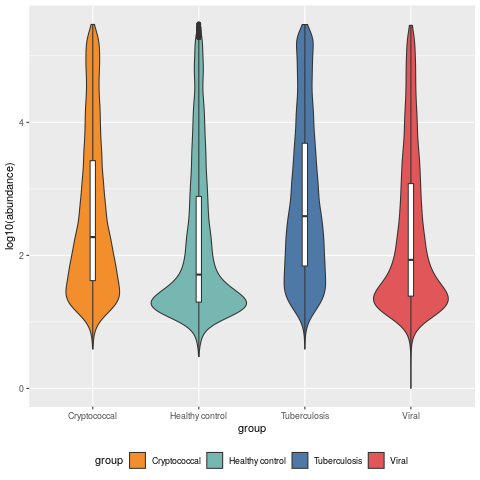

In [85]:
%%R
(
    ggplot(stacked, aes(x=group, y=log10(abundance), fill=group))
    + geom_violin()
    + geom_boxplot(fill='white', width=.05)
    + scale_fill_manual(values=patient_colors$Meningitis)
    + theme(legend.position='bottom')
)

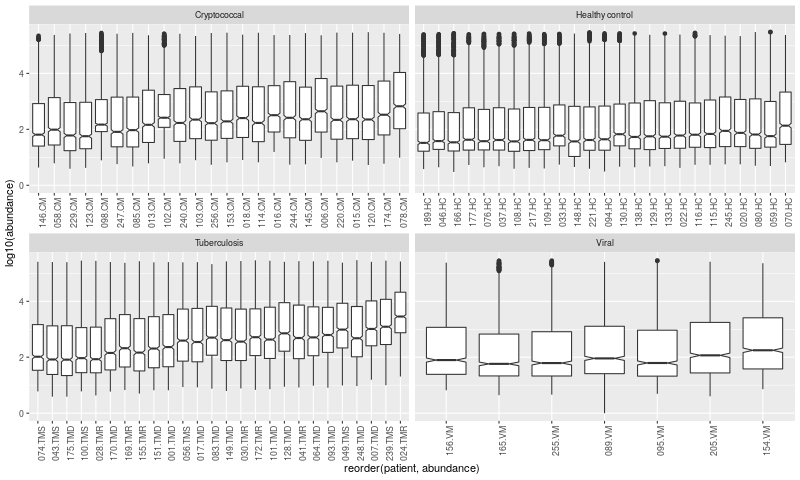

In [86]:
%%R -w 800
(
    ggplot(stacked, aes(x=reorder(patient, abundance), y=log10(abundance)))
    + facet_wrap('~ group', scale='free_x')
    + geom_boxplot(notch=T)
    + theme(axis.text.x = element_text(angle = 90))
)

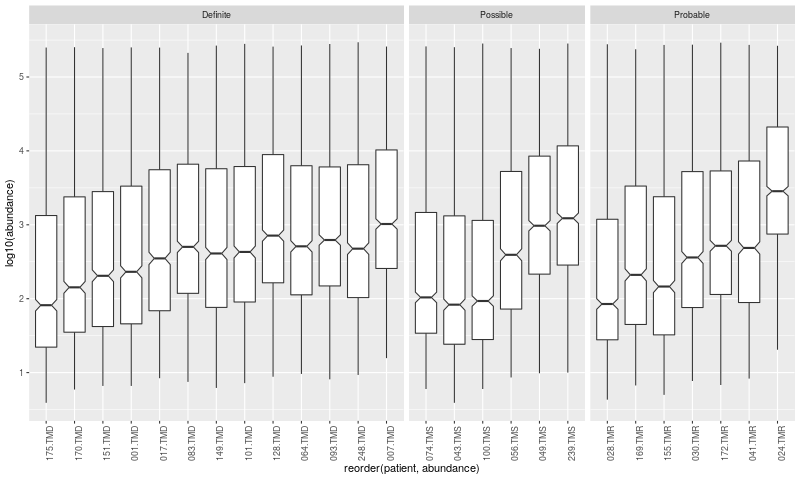

In [87]:
%%R -w 800
(
    ggplot(stacked[stacked$group == 'Tuberculosis',], aes(x=reorder(patient, abundance), y=log10(abundance)))
    + facet_grid('~ TB_status', scale='free_x', space='free_x')
    + geom_boxplot(notch=T)
    + scale_fill_manual(values=patient_colors$Meningitis)
    + theme(axis.text.x = element_text(angle = 90))
)

## Caveats of SOMAScan

A quick notes from [(Joshi and Mayr, 2018)](https://www.ahajournals.org/doi/full/10.1161/CIRCULATIONAHA.118.036823):
- non specificity, cross-reactivity a known problem
- SNPs a known problem too
- PTMs(!) a potential problem (IMO more than SNPs), an important consideration for signaling proteins and signaling pathways - these may be under-represented!

**Thus: (!!)**
Cross checking with RNA-seq is crucial and may hint us not only about the biological differences (i.e. SOMAScan detecting protein previously expressed and folded, while RNA-seq detecting proteins being actively expressed) but also about the discrepancies arising from failing SOMAScan failing to detect PTM modified signaling proteins or proteins bearing an important (and conformation changing) SNP.